<a href="https://colab.research.google.com/github/atuchiya/gf180-analog-tutorial/blob/main/fifty_nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fifty-Nifty Variations of Two-Transistor Circuits in GF180

Xschem schematic files :
https://github.com/atuchiya/gf180-analog-tutorial/tree/main/fifty-nifty

## 1. Introduction

This notebook investigates some circuits in Fifty-Nifty Variations on Two-Transistor Circuits in GlobalFoundries 180-nm CMOS ([gf180mcu](https://gf180mcu-pdk.readthedocs.io/en/latest/)). This document covers two design environments:
- ngspice in jupyter-notebook (this notebook)
- Xschem + ngspice in [IIC-OSIC-TOOLS tuned for Chipathon 2025](https://github.com/sscs-ose/sscs-chipathon-2025)

Reference: H. Pretl and M. Eberlein, "Fifty-Nifty Variations on Two-Transistor Circuits," IEEE Solid-State Circuits Magazine, vol. 13, No. 3, pp.38-46, 2021, doi:10.1109/MSSC.2021.3088968

### 1.1 Notation Rules

In thsi document, basic notation rule is as follows
- Upper case means large signal (including nonlinear effect). i.e. $V$, $I$, $R$, etc.
- Lower case means small signal (linear approximation), i.e. $v$, $i$, $r$, etc.
- Voltage $V$ with subscription, for example $V_{\mathrm{AB}}$, means voltage difference from node B to node A. Thus, $V_{\mathrm{AB}}=-V_{\mathrm{BA}}$.
- Some special variables:
  - $V_{\mathrm{DD}}$ : the supply voltage
  - $V_{\mathrm{SS}}$ : the common voltage (usually, equal to ground voltage (0 V))






##2. Installing ngspice and PDK

Simulation setup is adopted from [IEEE SSCS OSE Chipathon template](https://github.com/sscs-ose/sscs-ose-chipathon.github.io/blob/main/template_notebook_to_follow.ipynb)

In [1]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

ngspice_version = 'latest' #@param {type:"string"}
gf180mcu_fd_pr_version = 'latest' #@param {type:"string"}

if ngspice_version == 'latest':
  ngspice_version = ''

if gf180mcu_fd_pr_version == 'latest':
  gf180mcu_fd_pr_version = 'main'

import os
import pathlib
import urllib.request

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     ngspice={ngspice_version}

ngspice_models_dir = pathlib.Path('globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice')
ngspice_models_dir.mkdir(exist_ok=True, parents=True)
models = ['design.ngspice', 'sm141064.ngspice', 'sm141064_mim.ngspice', 'smbb000149.ngspice']
for m in models:
  url = f'https://github.com/efabless/globalfoundries-pdk-libs-gf180mcu_fd_pr/raw/{gf180mcu_fd_pr_version}/models/ngspice/{m}'
  print('downloading:', url)
  with urllib.request.urlopen(url) as src:
    with (ngspice_models_dir / m).open('wb') as dst:
      dst.write(src.read())

PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}

Empty environment created at prefix: /content/conda-env

Pinned packages:

  - python==3.7*


Transaction

  Prefix: /content/conda-env

  Updating specs:

   - ngspice


  Package                      Version  Build            Channel        Size
──────────────────────────────────────────────────────────────────────────────
  Install:
──────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                  0.1  main             main            3kB
  + _openmp_mutex                  5.1  1_gnu            main           21kB
  + libgcc-ng                   11.2.0  h1234567_1       main            9MB
  + libgomp                     11.2.0  h1234567_1       main          573kB
  + libstdcxx-ng                11.2.0  h1234567_1       main            6MB
  + ngspice        39.3_552_g902a62d2f  20240223_100318  litex-hub       3MB

  Summary:

  Install: 6 packages

  Total download: 19MB

────────────────────────────────────────────────────────────

In [2]:
%%writefile .spiceinit
set ngbehavior=hs

Writing .spiceinit


In [73]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##3. Logic Circuits

### #1 Digital Inverter

One of the basic logic circuit is inverter (NOT gate). When the input is low, the output is high. When the input is high, the output is low.

First, check Input-Output curve by DC analysis.

In [27]:
%%writefile 01_inv_dc.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND 0

.measure dc vlt when v(out)=1.65

.option savecurrent
.control
save all
dc VIN 0 3.3 0.01
wrdata 01_inv_dc.txt V(out) i(Vdd)
.endc
.end

Overwriting 01_inv_dc.spice


This netlsit includes `.measure` statement.
```
.measure dc vlt when v(out)=1.65
```
This statement means "find VIN value when v(out)=1.65". 1.65 V is $V_{\mathrm{DD}}/2$. This input voltage is the voltage where the output voltage flips. It is called "logic threshold voltage". The logic threshold voltage is determined by the ratio of pMOS channel width and nMOS channel width. In many processes, pMOS should be larger than nMOS.

In [29]:
!ngspice -b 01_inv_dc.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 331

  Measurements for DC Analysis

vlt                 =   1.61261e+00

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


  Measurements for DC Analysis

vlt                 =   1.61261e+00


Total analysis time (seconds) = 0.010673

Total CPU time (seconds) = 0.100 

Total DRAM available = 12977.945 MB.
DRAM currently available = 8849.953 MB.
Maximum ngspice program size =   18.629 MB.
Current ngspice program size =   13.652 MB.

Shared ngspice pages =    7.207 MB.
Text (code) pages =    5.102 MB.
Stack = 0 bytes.
Library pages =    7.418 MB.



The I-O curve and the current flow are shown.

/tmp/ipython-input-57-3794323346.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_dc.txt", delim_whitespace=True, header=None)


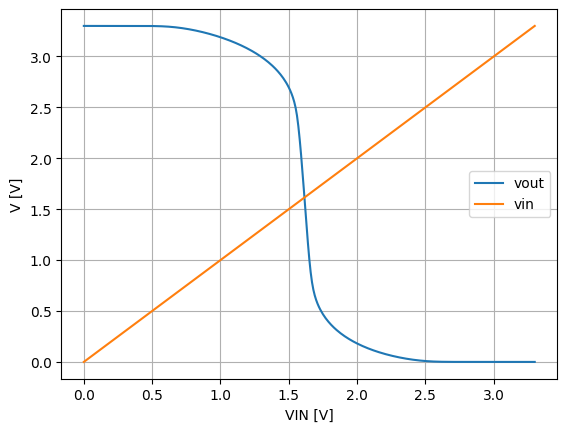

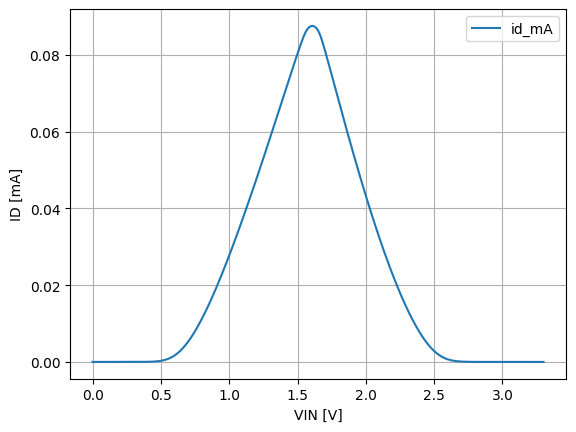

In [57]:
df = pd.read_csv("01_inv_dc.txt", delim_whitespace=True, header=None)
df.columns = ["vin", "vout", "vin_", "id"]
df['id_mA'] = df['id'] * -1000

plt.plot(df['vin'], df['vout'], label='vout')
plt.plot(df['vin'], df['vin'], label='vin')
plt.xlabel("VIN [V]")
plt.ylabel("V [V]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['vin'], df['id_mA'], label='id_mA')
plt.xlabel("VIN [V]")
plt.ylabel("ID [mA]")
plt.legend()
plt.grid(True)
plt.show()

Then, let's check transient waveform. The performance measures in transient analysis are:
- signal propagation delay : time from Vin=VDD/2 to Vout=VDD/2 (rising edge and falling edge)
- rise time : time from Vout=VDD\*0.2 to Vout=VDD\*0.8
- fall time : time from Vout=VDD\*0.8 to Vout=VDD\*0.2

These are obtained by `.measure` statements.

In [53]:
%%writefile 01_inv_tran.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND pwl 0 0 100n 0 120n 3.3 200n 3.3 220n 0
Cload out GND 100f

.measure tran tdr trig V(in) val=1.65 rise=1 targ V(out) val=1.65 fall=1
.measure tran tdf trig V(in) val=1.65 fall=1 targ V(out) val=1.65 rise=1
.measure tran tr trig V(out) val=0.66 rise=1 targ V(out) val=2.64 rise=1
.measure tran tf trig V(out) val=2.64 fall=1 targ V(out) val=0.66 fall=1

.option savecurrent
.control
save all
tran 1n 300n
wrdata 01_inv_tran.txt V(in) V(out) i(Vdd)
.endc
.end

Overwriting 01_inv_tran.spice


In [54]:
!ngspice -b 01_inv_tran.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
out                                        3.3
in                                           0
vdd                                        3.3
vin#branch                                   0
vdd#branch                        -3.80512e-12


No. of Data Rows : 322

  Measurements for Transient Analysis

tdr                 =  1.792869e-09 targ=  1.117929e-07 trig=  1.100000e-07
tdf                 =  2.252928e-09 targ=  2.122529e-07 trig=  2.100000e-07
tr                  =  2.772004e-09 targ=  2.134267e-07 trig=  2.106547e-07
tf                  =  2.994976e-09 targ=  1.130092e-07 trig=  1.100142e-07

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


  Measurements for Transient Analysis

tdr                 =  1.792869e

/tmp/ipython-input-59-2609420847.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_tran.txt", delim_whitespace=True, header=None)


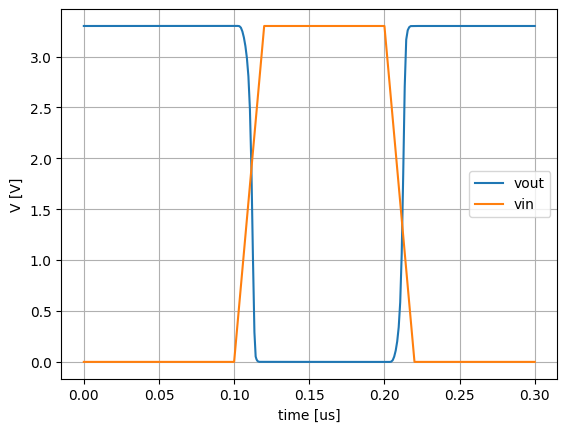

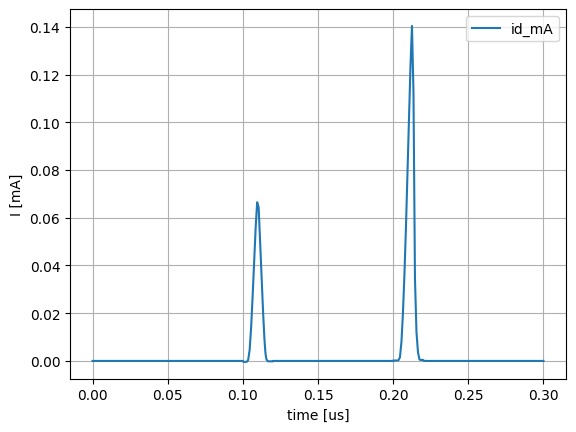

In [59]:
df = pd.read_csv("01_inv_tran.txt", delim_whitespace=True, header=None)
df.columns = ["time", "vin", "time_", "vout", "time__", "id"]
df['id_mA'] = df['id'] * -1000
df['t_us'] = df['time'] * 1e6

plt.plot(df['t_us'], df['vout'], label='vout')
plt.plot(df['t_us'], df['vin'], label='vin')
plt.xlabel("time [us]")
plt.ylabel("V [V]")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['t_us'], df['id_mA'], label='id_mA')
plt.xlabel("time [us]")
plt.ylabel("I [mA]")
plt.legend()
plt.grid(True)
plt.show()

This circuit can also work as an analog amplifier (push-pull amplifier).

In [67]:
%%writefile 01_inv_ac.spice
* INV

.include "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/design.ngspice"
.lib "globalfoundries-pdk-libs-gf180mcu_fd_pr/models/ngspice/sm141064.ngspice" typical

XM1 out in GND GND nfet_03v3 L=0.28u W=0.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
XM2 out in vdd vdd pfet_03v3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u' pd='2*int((nf+1)/2) * (W/nf + 0.18u)'
+ ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W' sa=0 sb=0 sd=0 m=1
VDD vdd GND 3.3
VIN in GND DC 1.65 AC 1
Cload out GND 100f

.option savecurrent
.control
save all
ac dec 20 1e6 1e10
wrdata 01_inv_ac.txt V(out)
.endc
.end

Overwriting 01_inv_ac.spice


In [68]:
!ngspice -b 01_inv_ac.spice


Note: Compatibility modes selected: hs



Circuit: * inv

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 81
Note: Simulation executed from .control section 


/tmp/ipython-input-80-1345131209.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("01_inv_ac.txt", delim_whitespace=True, header=None)


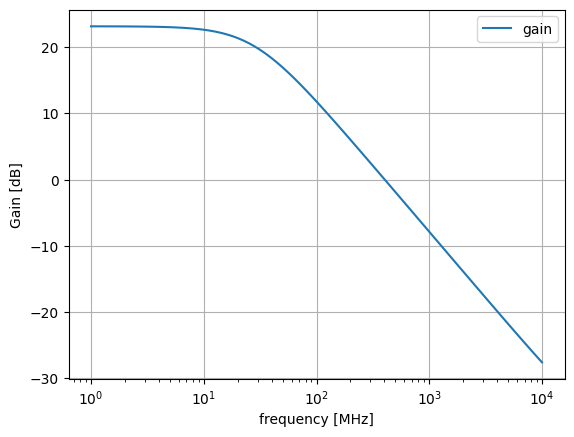

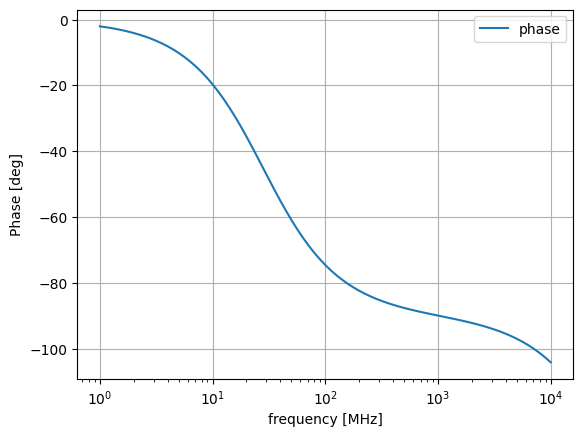

In [80]:
df = pd.read_csv("01_inv_ac.txt", delim_whitespace=True, header=None)
df.columns = ["freq", "real", "img"]
z = df['real'] + 1j * df['img']
df["gain_dB"] = 20 * np.log10(np.abs(z))
df["phase_deg"] = np.degrees(np.angle(z)) - 180
df['freq_MHz'] = df['freq'] / 1e6

plt.plot(df['freq_MHz'], df['gain_dB'], label="gain")
plt.xlabel("frequency [MHz]")
plt.ylabel("Gain [dB]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(df['freq_MHz'], df['phase_deg'], label="phase")
plt.xlabel("frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()
